# ***Major League Cricket Data Analysis***
### by [***Anthahkarana***](https://anthahkarana.tech)

### **Third Round of Analysis**
Trying out new things with respect to the 2024 season.

Defining the Folder Path where I have uploaded the ball-by-ball database of every MLC match. Credits to [CricSheet](https://cricsheet.org)

In [ ]:
folder_path='/content/mlc_json'

All the JSON files by cricsheet are well-defined with comprehensive data. Some of them just need to be connected in order to perform further analysis. Here, I am map each player to their respective team for the 2024 season.

In [129]:
import os
import json


# Dictionary to store player-to-team mappings across all files
team_mapping = {}

# Process each JSON file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):  # Process only JSON files
        file_path = os.path.join(folder_path, filename)

        # Load the JSON data
        with open(file_path, 'r') as file:
            match_data = json.load(file)

        season = match_data.get('info', {}).get('season')
        if season != '2024':
            continue

        # Extract players and registry data
        players_data = match_data.get('info', {}).get('players', {})
        registry_data = match_data.get('info', {}).get('registry', {}).get('people', {})

        # Create the player-to-team mapping for this file
        for team, players in players_data.items():
            for player_short_name in players:
                for full_player_name, player_id in registry_data.items():
                    if player_short_name == full_player_name:
                        team_mapping[full_player_name] = team
                        break

# Print the resulting dictionary
print(team_mapping)


{'JJ Roy': 'Los Angeles Knight Riders', 'SP Narine': 'Los Angeles Knight Riders', 'UBT Chand': 'Los Angeles Knight Riders', 'Shakib Al Hasan': 'Los Angeles Knight Riders', 'NR Kumar': 'Los Angeles Knight Riders', 'DA Miller': 'Los Angeles Knight Riders', 'AD Russell': 'Los Angeles Knight Riders', 'DYA Davis': 'Los Angeles Knight Riders', 'CA Dry': 'Los Angeles Knight Riders', 'SH Johnson': 'Los Angeles Knight Riders', 'Ali Khan': 'Los Angeles Knight Riders', 'FH Allen': 'San Francisco Unicorns', 'J Fraser-McGurk': 'San Francisco Unicorns', 'MW Short': 'San Francisco Unicorns', 'JP Inglis': 'San Francisco Unicorns', 'CJ Anderson': 'San Francisco Unicorns', 'Hassan Khan': 'San Francisco Unicorns', 'SP Krishnamurthi': 'San Francisco Unicorns', 'BL Couch': 'San Francisco Unicorns', 'LE Plunkett': 'San Francisco Unicorns', 'Haris Rauf': 'San Francisco Unicorns', 'Abrar Ahmed': 'San Francisco Unicorns', 'RD Rickelton': 'Seattle Orcas', 'Aaron Jones': 'Seattle Orcas', 'Q de Kock': 'Seattle Or

Loading the necessary models and creating a variable which can load all the JSON files.

In [128]:
import pandas as pd
import glob
import os
import json


all_files = glob.glob(os.path.join(folder_path, "*.json"))



Now, we have the total number of runs scored by each player in the MLC. Moving onto sorting the top ten players.

Trying to draw a scatter-plot now with runs and balls as th two parameters, processing the data..

In [127]:
player_stats = {}  # Store runs and balls faced for each player

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                batter_name = delivery.get('batter')
                runs_scored = delivery.get('runs', {}).get('batter', 0)
                is_wide = delivery.get('extras', {}).get('wides', 0) > 0
                is_no_ball = delivery.get('extras', {}).get('noballs', 0) > 0

                batter_identifier = registry.get(batter_name)

                if batter_identifier:
                    if batter_name not in player_stats:
                        player_stats[batter_name] = {'runs': 0, 'balls': 0}

                    player_stats[batter_name]['runs'] += runs_scored
                    if not is_wide and not is_no_ball:  # Count balls faced excluding wides & no-balls
                        player_stats[batter_name]['balls'] += 1

Trying to install a library which can make the graph interactive..

In [ ]:
!pip install mplcursors

Plotting the scatter-plot

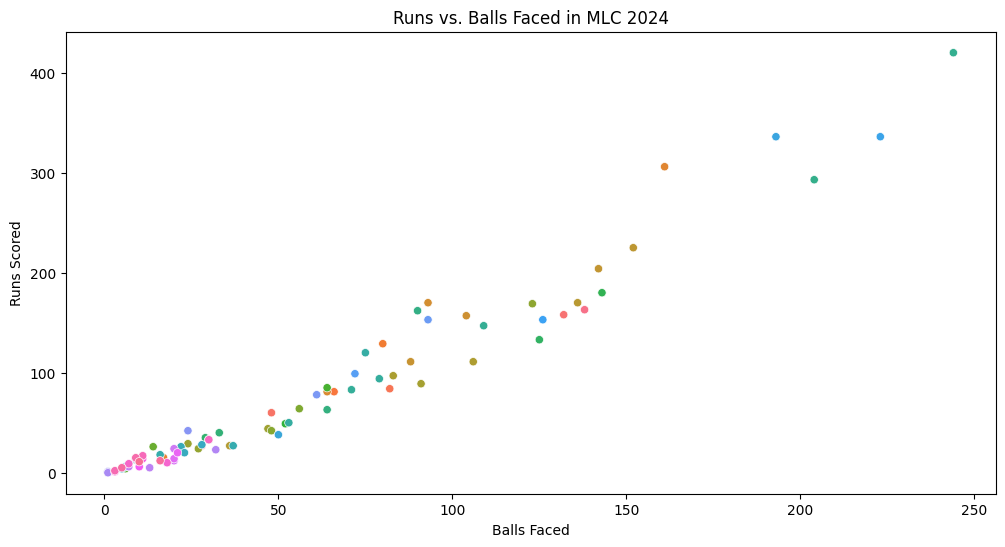

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mplcursors


# Convert player_stats to DataFrame
df = pd.DataFrame(player_stats).T.reset_index()
df.columns = ['Player', 'Runs', 'Balls']

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))
scatter = sns.scatterplot(x='Balls', y='Runs', data=df, hue='Player', legend=False, ax=ax)

# Create annotation object (initially hidden)
annot = ax.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

# Function to update annotation text and position
def update_annot(sel):
    index = sel.target.index
    annot.xy = sel.target
    annot.set_text(df['Player'][index])
    annot.get_bbox_patch().set_alpha(0.4)
    annot.set_visible(True)

# Connect hover event to update_annot function
cursor = mplcursors.cursor(scatter, hover=True)
cursor.connect("add", update_annot)

# Customize plot (as before)
plt.title('Runs vs. Balls Faced in MLC 2024')
plt.xlabel('Balls Faced')
plt.ylabel('Runs Scored')

# Show the plot
plt.show()


This shows a proper scatter-plot, but notice that it is not interactive. Trying out a different library named 'plotly' now to make it interactive

In [ ]:
!pip install plotly

In [125]:
import plotly.express as px
import pandas as pd

# Convert player_stats to DataFrame
df = pd.DataFrame(player_stats).T.reset_index()
df.columns = ['Player', 'Runs', 'Balls']

# Create an interactive scatter plot using Plotly
fig = px.scatter(df, x='Balls', y='Runs', color='Player',
                 title='Runs vs. Balls Faced in MLC 2024',
                 labels={'Balls': 'Balls Faced', 'Runs': 'Runs Scored'})

# Update hover data to show player name only on hover
fig.update_traces(hoverinfo='text+x+y', hovertext=df['Player'])

# Customize the layout
fig.update_layout(
    hoverlabel=dict(bgcolor='white'),
    showlegend=False  # Hide the legend to avoid displaying player names
)

# Show the plot
fig.show()


And voila! it works.
As we can see Faf Du Plessis is on top of the charts. This graph also allows us to see how fast individual batsem are with respect to scoring runs. One noticeable element is that Finn Allen scoring more runs than Devon Conway with around 40 lesser balls. And post 150 runs, we see only fewer players who are establishing their class!

Now trying distribution graph..

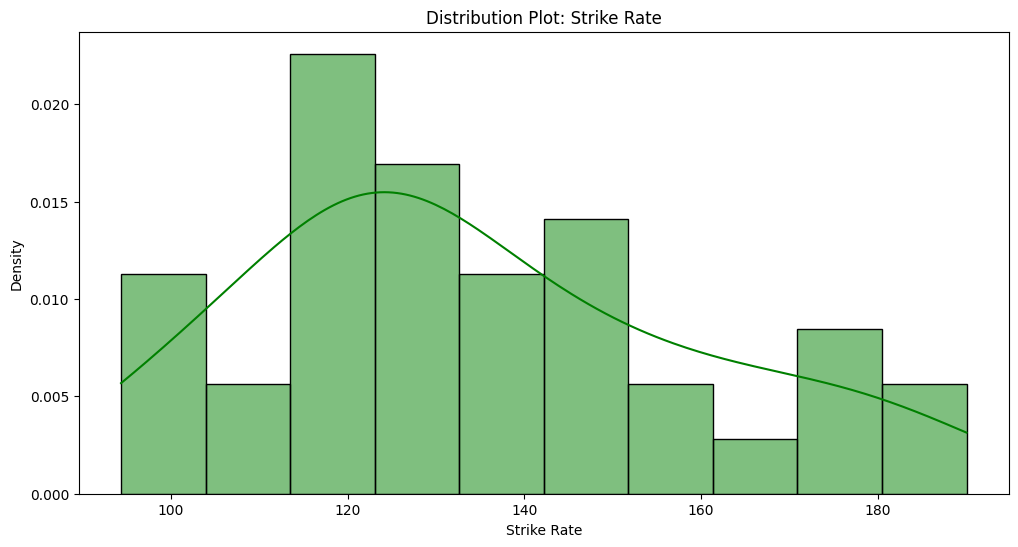

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert player_stats to DataFrame
df = pd.DataFrame(player_stats).T.reset_index()
df.columns = ['Player', 'Runs', 'Balls']

# Calculate Strike Rate
df['Strike Rate'] = (df['Runs'] / df['Balls']) * 100

# Filter the DataFrame for players with runs >= 50 since lesser runs might not give accurate results.
df_filtered = df[df['Runs'] >= 50]

# Create a distribution plot for Strike Rate
plt.figure(figsize=(12, 6))

# Plot the distribution of 'Strike Rate'
sns.histplot(data=df_filtered, x='Strike Rate', kde=True, color='green', stat='density', bins=10)

# Customize plot
plt.title('Distribution Plot: Strike Rate')
plt.xlabel('Strike Rate')
plt.ylabel('Density')

# Show the plot
plt.show()


This shows that the region around 120 is strike rate which most batsmen have, emphasizing the role big-hitters have as they are rare in this format..

Now trying to do something a bit more complex which will shed some light on bowler effectiveness..

Calculate the total number of wickets by each bowler in the 2024 season

In [123]:
wickets_by_bowler = {}

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                if 'wickets' in delivery:
                    for wicket in delivery['wickets']:
                        bowler_name = delivery.get('bowler')
                        kind = wicket.get('kind')  # Extract kind of dismissal

                        if kind != 'run out':  # Exclude run outs
                            bowler_identifier = registry.get(bowler_name)

                            if bowler_identifier:  # Ensure bowler exists in the registry
                                wickets_by_bowler[bowler_name] = wickets_by_bowler.get(bowler_name, 0) + 1



Calculate the total runs conceded by each bowler in the 2024 season

In [122]:
runs_conceded_by_bowler = {}

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                bowler_name = delivery.get('bowler')
                runs_conceded = delivery.get('runs', {}).get('total', 0)  # Total runs conceded

                # Exclude byes and legbyes
                byes = delivery.get('extras', {}).get('byes', 0)
                legbyes = delivery.get('extras', {}).get('legbyes', 0)
                runs_conceded -= (byes + legbyes)

                bowler_identifier = registry.get(bowler_name)

                if bowler_identifier:
                    runs_conceded_by_bowler[bowler_name] = runs_conceded_by_bowler.get(bowler_name, 0) + runs_conceded

Calculate the bowling average of each bowler in the 2024 season

In [121]:
bowling_averages = {}

for bowler, wickets in wickets_by_bowler.items():
    runs_conceded = runs_conceded_by_bowler.get(bowler, 0)
    if wickets > 0:  # Avoid division by zero if a bowler hasn't taken any wickets
        bowling_averages[bowler] = runs_conceded / wickets
    else:
        bowling_averages[bowler] = float('inf')  # Or any other suitable value

Just forgot the I hadn't created a dataframe to store this data, so doing it now

In [120]:
# Create a list of lists to store the data
data = []
for bowler in wickets_by_bowler:
    wickets = wickets_by_bowler.get(bowler, 0)
    runs_conceded = runs_conceded_by_bowler.get(bowler, 0)
    average = bowling_averages.get(bowler, float('inf'))
    data.append([bowler, average, wickets, runs_conceded])

# Create the DataFrame
df_bowler_stats = pd.DataFrame(data, columns=['Bowler', 'Average', 'Wickets', 'Runs Conceded'])

Exporting to a CSV file

In [119]:
df_bowler_stats.to_csv('bowler_stats.csv', index=False)

Calculating the total number of balls bowled by the bowler

In [139]:
balls_bowled_by_bowler = {}

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                bowler_name = delivery.get('bowler')
                is_wide = delivery.get('extras', {}).get('wides', 0) > 0
                is_no_ball = delivery.get('extras', {}).get('noballs', 0) > 0

                bowler_identifier = registry.get(bowler_name)

                if bowler_identifier:
                    balls_bowled_by_bowler[bowler_name] = balls_bowled_by_bowler.get(bowler_name, 0) + 1

df_bowler_stats['Balls Bowled'] = 0  # Initialize the column

# Populate the column with data from balls_bowled_by_bowler dictionary
for index, row in df_bowler_stats.iterrows():
    bowler = row['Bowler']
    df_bowler_stats.loc[index, 'Balls Bowled'] = balls_bowled_by_bowler.get(bowler, 0)

# To export to csv:
df_bowler_stats.to_csv('bowler_stats.csv', index=False)

Calculating the strike rate of each bowler..

In [140]:
df_bowler_stats['Strike Rate'] = 0.0  # Initialize the 'Strike Rate' column

for index, row in df_bowler_stats.iterrows():
    bowler = row['Bowler']
    wickets = row['Wickets']
    balls_bowled = balls_bowled_by_bowler.get(bowler, 0)

    if wickets > 0:
        strike_rate = balls_bowled / wickets
    else:
        strike_rate = float('inf')  # or any suitable value for 0 wickets

    df_bowler_stats.loc[index, 'Strike Rate'] = strike_rate

Here comes the tricky part

Average and Strike Rate by themselves do not give the actual impact a player has had on the game.

So I have created a normalized scale which rates both average and strike rate of each player on a scale of 0-5. Higher the Average and Strike Rate, lesser the score.

Note that it is a normalized scale, so the player with the best average here will have a score of 5 and vice versa


Working on the Average Score..

In [141]:
# Invert the average (lower average is better)
df_bowler_stats['Inverted Average'] = 1 / df_bowler_stats['Average']

# Replace inf with 0 for proper scaling
df_bowler_stats['Inverted Average'].replace(float('inf'), 0, inplace=True)

# Normalize and scale to 0-5 range
df_bowler_stats['Average Score'] = (df_bowler_stats['Inverted Average'] - df_bowler_stats['Inverted Average'].min()) / (df_bowler_stats['Inverted Average'].max() - df_bowler_stats['Inverted Average'].min()) * 4 + 1  # Scale to 5

# Remove the temporary 'Inverted Average' column
df_bowler_stats.drop(columns=['Inverted Average'], inplace=True)

<ipython-input-141-a4a663c466a8>:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Working on the Strike Rate Score..

In [142]:
# Invert the strike rate (lower strike rate is better)
df_bowler_stats['Inverted Strike Rate'] = 1 / df_bowler_stats['Strike Rate']

# Replace inf with 0 for proper scaling
df_bowler_stats['Inverted Strike Rate'].replace(float('inf'), 0, inplace=True)

# Normalize and scale to 0-5 range
df_bowler_stats['Strike Rate Score'] = (df_bowler_stats['Inverted Strike Rate'] - df_bowler_stats['Inverted Strike Rate'].min()) / (df_bowler_stats['Inverted Strike Rate'].max() - df_bowler_stats['Inverted Strike Rate'].min()) * 4 + 1  # Scale to 5

# Remove the temporary 'Inverted Strike Rate' column
df_bowler_stats.drop(columns=['Inverted Strike Rate'], inplace=True)

<ipython-input-142-76c9b9aad0fc>:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





A similar score for wickets as well, on a scale of 1-5 since by this point I realized that a person with 1 wicket will get a score of 0 which isn't justifiable.

So this scale out here will give 5 to the highest wicket taker of the tournament.

In [143]:
df_bowler_stats['Wickets Score'] = (df_bowler_stats['Wickets'] - df_bowler_stats['Wickets'].min()) / (df_bowler_stats['Wickets'].max() - df_bowler_stats['Wickets'].min()) * 4 + 1  # Scale to 4 and shift by 1

#To export to csv:
df_bowler_stats.to_csv('bowler_stats.csv', index=False)

But, Suppose a player has just bowled 2 balls and taken a wicket by conceding 1 run, his scores might be the highest in 'Average Score' and 'Strike Rate Score' parameters. And this is not accurate.

So I have come up with a new scale for both of these scores where

**If a player has more than 4 wickets, then the scale is 3-5
and if lesser than or equal to 4, then the scale should is 1-2.9**

And since the number of wickets should have more weightage ultimately.
Both of these scores have been divided by 2 such that the maximum score in both of these equals 2.5

Ultimately giving us a total score out of 10

In [144]:
def update_scores(df):
    # Normalize Average
    df['Inverted Average'] = 1 / df['Average']
    df['Inverted Average'].replace(float('inf'), 0, inplace=True)

    # Apply different scales based on wickets
    df['Average Score'] = 0
    df.loc[df['Wickets'] > 4, 'Average Score'] = (df['Inverted Average'] - df['Inverted Average'].min()) / (
                df['Inverted Average'].max() - df['Inverted Average'].min()) * 2 + 3  # Scale to 3-5
    df.loc[df['Wickets'] <= 4, 'Average Score'] = (df['Inverted Average'] - df['Inverted Average'].min()) / (
                df['Inverted Average'].max() - df['Inverted Average'].min()) * 2.9 + 1  # Scale to 1-2.9

    df.drop(columns=['Inverted Average'], inplace=True)

    # Normalize Strike Rate
    df['Inverted Strike Rate'] = 1 / df['Strike Rate']
    df['Inverted Strike Rate'].replace(float('inf'), 0, inplace=True)

    df['Strike Rate Score'] = 0
    df.loc[df['Wickets'] > 4, 'Strike Rate Score'] = (df['Inverted Strike Rate'] - df['Inverted Strike Rate'].min()) / (
                df['Inverted Strike Rate'].max() - df['Inverted Strike Rate'].min()) * 2 + 3  # Scale to 3-5
    df.loc[df['Wickets'] <= 4, 'Strike Rate Score'] = (df['Inverted Strike Rate'] - df['Inverted Strike Rate'].min()) / (
                df['Inverted Strike Rate'].max() - df['Inverted Strike Rate'].min()) * 2.9 + 1  # Scale to 1-2.9

    df.drop(columns=['Inverted Strike Rate'], inplace=True)

    df['Average Score'] = df['Average Score'] / 2
    df['Strike Rate Score'] = df['Strike Rate Score'] / 2
    return df

# Working on the dataframe
df_bowler_stats = update_scores(df_bowler_stats)
df_bowler_stats.to_csv('bowler_stats.csv', index=False)

<ipython-input-144-72a2976260eb>:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-144-72a2976260eb>:8: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.84277768 5.         3.55553807 3.71238895 3.4183001  3.69181198
 3.64460598 3.84435366 3.58713782 4.86469936 3.41940308 3.48806797
 3.36881329 4.1006337  3.57870768 3.3478826  3.76876422 3.4865208
 3.41339295 3.55116732 3.5007401  3.45745302 3.36486676 3.32018358
 3.10767795]' has

And this is the final score for each player!

In [145]:
new_order = ['Bowler', 'Wickets',  'Wickets Score', 'Runs Conceded', 'Balls Bowled', 'Average', 'Average Score', 'Strike Rate', 'Strike Rate Score', 'Total Score']
df_bowler_stats = df_bowler_stats[new_order]

In [146]:
# Calculate the total score
df_bowler_stats['Total Score'] = df_bowler_stats['Average Score'] + df_bowler_stats['Strike Rate Score'] + df_bowler_stats['Wickets Score']

# Sort the DataFrame by 'Total Score' in descending order
df_bowler_stats = df_bowler_stats.sort_values(by='Total Score', ascending=False)

# Display the sorted DataFrame
display(df_bowler_stats)

#To export to csv:
df_bowler_stats.to_csv('bowler_stats.csv', index=False)

,Bowler,Wickets,Wickets Score,Runs Conceded,Balls Bowled,Average,Average Score,Strike Rate,Strike Rate Score,Total Score
42,SN Netravalkar,15,5.000000,202,160,13.466667,1.921389,10.666667,2.025528,8.946917
34,R Ravindra,12,4.142857,73,92,6.083333,2.500000,7.666667,2.264238,8.907095
11,CJ Gannon,11,3.857143,212,142,19.272727,1.777769,12.909091,1.919560,7.554472
8,Hassan Khan,10,3.571429,156,132,15.600000,1.856194,13.200000,1.908451,7.336074
41,M Jansen,11,3.857143,267,206,24.272727,1.709150,18.727273,1.762956,7.329249
14,Rashid Khan,10,3.571429,160,158,16.000000,1.845906,15.800000,1.827331,7.244666
32,GJ Maxwell,10,3.571429,170,156,17.000000,1.822303,15.600000,1.832611,7.226343
31,Noor Ahmad,9,3.285714,121,99,13.444444,1.922177,11.000000,2.007042,7.214933
45,LH Ferguson,10,3.571429,184,161,18.400000,1.793569,16.100000,1.819657,7.184655
33,Jasdeep Singh,6,2.428571,39,45,6.500000,2.432350,7.500000,2.283099,7.144020


As we can see, Netravalkar just marginally edged out Ravindra for the top place. If the average score wasn't normalized to 2.5, then Ravindra would have taken the top spot but this seems more accurate.

Netravalkar and Rachin are miles ahead of the pack while Jasdeep Singh with 6 wickets has leapfrogged four players who have more wickets than him to the 10th rank. This shows the effectiveness of normalization and considering both average and strike rate.

Now a scatter-plot to depict the same..

In [147]:
import plotly.express as px
import pandas as pd

# Select the desired columns from df_bowler_stats
df = df_bowler_stats[['Bowler', 'Wickets', 'Total Score']]

# Create an interactive scatter plot using Plotly
fig = px.scatter(df,
                 x='Wickets',
                 y='Total Score',
                 color='Bowler',
                 title='Wickets against Total Score for bowlers in MLC 2024',
                 labels={'Wickets': 'Wickets Taken', 'Total Score': 'Total Normalized Score'})

# Update hover data to show player name only on hover
fig.update_traces(hoverinfo='text+x+y', hovertext=df['Bowler'])

# Customize the layout
fig.update_layout(
    hoverlabel=dict(bgcolor='white'),
    showlegend=False  # Hide the legend to avoid displaying player names
)

# Show the plot
fig.show()